# EVM Price Improvements

This document presents the results of analyzing collected data for opcode usage in `???` blocks. The analysis provide the following information:

- [Opcode Usage](#Histogram-+-pie-chart-of-opcodes)
- [PUSH0](#Add-PUSH0)
- [Gas consumed by the INVALID opcode](#Do-not-consume-all-gas-on-INVALID)
- [Repricing](#Repricing)
- [Fractional Gas Repricing](#Fractional-gas)
- [Fractional/Rounded Gas Repricing](#Fractional/Rounded-Gas-Repricing)

---

## Histogram + pie chart of opcodes

- Data as a spreadsheet/python notebook
- Aggregated for at least 1M blocks



---

## Add PUSH0

- [EIP Draft](https://notes.ethereum.org/l15y5F-tTQ6jftsqF7y6Ag)



---

## Do not consume all gas on `INVALID`


---

## Repricing

Based on the following histogram collected by tracing blocks and counting the number of executed opcodes:

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
INPUT_FILE = '../data/histogram.csv'

In [2]:
df = pd.read_csv(INPUT_FILE)

# Drop empty columns
for col_name in ['-' if i == 0 else '-.' + str(i) for i in range(0,114)]:
    df = df.drop(col_name, 1)

df

,Block#,Gas used,STOP,ADD,MUL,SUB,DIV,SDIV,MOD,SMOD,ADDMOD,MULMOD,EXP,SIGNEXTEND,LT,GT,SLT,SGT,EQ,ISZERO,AND,OR,XOR,NOT,BYTE,SHL,SHR,SAR,KECCAK256,ADDRESS,BALANCE,ORIGIN,CALLER,CALLVALUE,CALLDATALOAD,CALLDATASIZE,CALLDATACOPY,CODESIZE,CODECOPY,GASPRICE,EXTCODESIZE,EXTCODECOPY,RETURNDATASIZE,RETURNDATACOPY,EXTCODEHASH,BLOCKHASH,COINBASE,TIMESTAMP,NUMBER,DIFFICULTY,GASLIMIT,CHAINID,SELFBALANCE,POP,MLOAD,MSTORE,MSTORE8,SLOAD,SSTORE,JUMP,JUMPI,PC,MSIZE,GAS,JUMPDEST,PUSH1,PUSH2,PUSH3,PUSH4,PUSH5,PUSH6,PUSH7,PUSH8,PUSH9,PUSH10,PUSH11,PUSH12,PUSH13,PUSH14,PUSH15,PUSH16,PUSH17,PUSH18,PUSH19,PUSH20,PUSH21,PUSH22,PUSH23,PUSH24,PUSH25,PUSH26,PUSH27,PUSH28,PUSH29,PUSH30,PUSH31,PUSH32,DUP1,DUP2,DUP3,DUP4,DUP5,DUP6,DUP7,DUP8,DUP9,DUP10,DUP11,DUP12,DUP13,DUP14,DUP15,DUP16,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP6,SWAP7,SWAP8,SWAP9,SWAP10,SWAP11,SWAP12,SWAP13,SWAP14,SWAP15,SWAP16,LOG0,LOG1,LOG2,LOG3,LOG4,CREATE,CALL,CALLCODE,RETURN,DELEGATECALL,CREATE2,STATICCALL,REVERT,INVALID,SELFDESTRUCT,PUSH0
0,8567259,8087132,82,3230,184,854,511,0,9,0,0,2,498,0,657,460,28,10,2049,2748,2231,79,0,104,0,21,7,0,617,15,0,0,319,148,507,233,41,0,13,0,32,0,35,4,0,2,0,14,5,0,0,0,0,5422,1283,2395,0,709,224,2592,3864,0,0,58,4619,8842,6809,42,2233,30,1,8,72,0,0,0,33,9,0,0,0,0,0,0,1067,1,0,0,0,0,0,0,6,138,0,7,378,3930,3261,2276,1434,1134,452,218,221,180,87,48,54,35,6,6,2,4581,2321,1077,400,163,66,59,29,27,36,10,2,2,0,0,0,0,4,8,92,10,1,45,0,65,8,0,12,0,0,0,2526
1,8567261,8076091,101,6905,683,1707,940,0,16,0,0,1,1581,11,1919,695,13,20,3390,5767,4581,140,0,519,330,6,1,0,1157,35,10,0,435,193,675,330,58,17,73,2,65,0,56,18,0,0,0,30,9,4,1,0,0,8766,2768,4333,154,1637,315,4173,7254,4,3,92,8261,19314,12438,8,3843,13,0,2,89,10,13,1,29,9,0,1,6,5,0,8,1683,7,0,2,0,5,0,0,1,172,0,0,271,6862,6780,3692,2635,1873,721,312,601,283,178,86,59,39,31,16,31,10011,4243,1932,735,245,95,57,35,27,26,8,2,4,0,0,0,0,12,6,110,10,0,76,0,101,20,0,7,2,0,0,5149
2,8567262,8082858,53,9571,1473,1466,1535,0,45,0,0,0,802,4,1547,822,0,2,2947,5471,5161,238,0,434,161,142,29,0,642,11,2,0,216,154,398,308,23,9,10,0,92,0,148,25,0,0,0,87,1,2,0,0,0,9274,3559,4282,74,2361,969,3747,6915,0,0,113,8349,21983,12718,277,2285,6,0,1,50,0,0,0,0,5,0,0,0,0,0,0,1258,2,0,1,0,0,0,0,0,172,0,0,89,7637,7211,5698,2231,1305,685,444,302,215,24,14,23,7,6,7,0,9010,3578,1929,601,168,83,37,25,12,11,11,0,0,0,0,0,0,3,0,51,5,0,64,0,113,18,0,32,2,0,0,4253
3,8567263,8073204,49,9388,1111,1714,1495,0,5,0,0,0,1526,0,1541,641,0,0,3130,6079,4459,175,2,323,2,92,18,0,1385,37,1,8,262,212,613,369,40,13,27,2,151,0,165,19,0,2,1,12,12,0,1,0,0,10426,3353,5338,15,2415,741,3981,6768,0,1,167,8171,22898,12153,25,3363,26,4,18,39,1,1,1,0,10,0,0,49,14,0,0,1955,0,0,0,0,0,3,0,5,240,0,0,215,7404,8223,4401,2626,1289,822,526,687,317,182,71,81,75,47,93,109,10218,3736,2189,471,293,133,77,34,22,117,12,8,4,0,1,0,0,15,6,66,9,0,140,0,185,18,1,16,0,0,0,6250
4,8567265,8051312,25,10195,1739,1210,1691,0,0,0,0,0,603,0,1206,392,20,0,871,4011,3170,318,0,308,1,2,2,0,583,9,2,0,97,120,285,196,9,1,1,0,66,0,67,3,0,0,0,125,0,0,0,0,0,6452,3431,4245,0,2897,1319,2146,3337,1,0,72,4519,17643,7744,121,857,2,0,0,29,0,0,0,0,1,0,0,7,1,0,0,1216,2,0,0,0,0,0,0,0,157,0,0,54,5466,7243,4850,1512,880,479,174,115,32,9,5,2,1,3,0,1,6956,2391,949,127,21,73,2,3,3,0,0,1,1,0,0,0,0,4,2,25,2,0,64,0,75,4,0,3,4,0,0,2872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29133,12817394,15016052,122,13446,2217,3515,1199,1,17,1,0,8,1286,111,2930,2231,61,45,3769,7376,7103,505,1,537,120,1193,380,3,1051,88


- Reduce by 1 gas (usually from `3` to `2`) for 4 groups of instructions:
    - PUSHx
    - DUPx
    - SWAPx
    - Arithmetic (ADD, SUB, LT, GT, ISZERO, SHL, SHR)
    

### PUSHx

In [3]:
push_opcodes = ['PUSH' + str(i) for i in range(1, 33)]

# Get the sum of all PUSH opcodes into one column PUSH_TOTAL
df['PUSH_TOTAL'] = df[push_opcodes].sum(axis=1)
df[['Block#'] + push_opcodes + ['PUSH_TOTAL']]

,Block#,PUSH1,PUSH2,PUSH3,PUSH4,PUSH5,PUSH6,PUSH7,PUSH8,PUSH9,PUSH10,PUSH11,PUSH12,PUSH13,PUSH14,PUSH15,PUSH16,PUSH17,PUSH18,PUSH19,PUSH20,PUSH21,PUSH22,PUSH23,PUSH24,PUSH25,PUSH26,PUSH27,PUSH28,PUSH29,PUSH30,PUSH31,PUSH32,PUSH_TOTAL
0,8567259,8842,6809,42,2233,30,1,8,72,0,0,0,33,9,0,0,0,0,0,0,1067,1,0,0,0,0,0,0,6,138,0,7,378,19676
1,8567261,19314,12438,8,3843,13,0,2,89,10,13,1,29,9,0,1,6,5,0,8,1683,7,0,2,0,5,0,0,1,172,0,0,271,37930
2,8567262,21983,12718,277,2285,6,0,1,50,0,0,0,0,5,0,0,0,0,0,0,1258,2,0,1,0,0,0,0,0,172,0,0,89,38847
3,8567263,22898,12153,25,3363,26,4,18,39,1,1,1,0,10,0,0,49,14,0,0,1955,0,0,0,0,0,3,0,5,240,0,0,215,41020
4,8567265,17643,7744,121,857,2,0,0,29,0,0,0,0,1,0,0,7,1,0,0,1216,2,0,0,0,0,0,0,0,157,0,0,54,27834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29133,12817394,30664,20960,52,3883,226,0,16,53,8,2,2,1,108,253,68,30,16,0,0,1822,10,12,12,4,2,0,0,98,220,0,45,832,59399
29134,12817398,34051,20698,58,4449,131,0,17,55,18,25,5,14,67,191,50,34,4,0,0,1655,9,0,0,2,0,0,0,83,169,0,2,786,62573
29135,12817402,37310,20182,236,4914,179,0,36,119,11,55,6,24,41,66,33,162,21,0,0,1230,11,0,0,5,0,0,0,50,119,0,4,676,65490
29136,12817403,27388,18320,40,3825,150,0,17,60,3,12,1,18,16,320,88,10,2,0,0,1571,11,0,0,2,0,0,0,126,179,0,1,879,53039


In [4]:
# Calculate the gas cost for all PUSH opcodes considering a gas cost of 3
gas_cost = 3
df['PUSH_GAS'] = df['PUSH_TOTAL'] * gas_cost

# Calculate gas cost for all PUSH code considering a gas repricing from 3 to 2
new_gas_cost = 2
df['PUSH_GAS_RP'] = df['PUSH_TOTAL'] * new_gas_cost

# Get the difference
df['PUSH_GAS_DIF'] = df['PUSH_GAS'] - df['PUSH_GAS_RP']

df[['Block#', 'PUSH_TOTAL', 'PUSH_GAS', 'PUSH_GAS_RP', 'PUSH_GAS_DIF']]

,Block#,PUSH_TOTAL,PUSH_GAS,PUSH_GAS_RP,PUSH_GAS_DIF
0,8567259,19676,59028,39352,19676
1,8567261,37930,113790,75860,37930
2,8567262,38847,116541,77694,38847
3,8567263,41020,123060,82040,41020
4,8567265,27834,83502,55668,27834
...,...,...,...,...,...
29133,12817394,59399,178197,118798,59399
29134,12817398,62573,187719,125146,62573
29135,12817402,65490,196470,130980,65490
29136,12817403,53039,159117,106078,53039


After repricing PUSH costs from `3` to `2` we get an average reduction of `0.44%`:

In [5]:
def autopct(pct):
    return ('%.2f' % pct) + "%" if pct > 0 else ''

<AxesSubplot:ylabel='PUSH Repricing'>

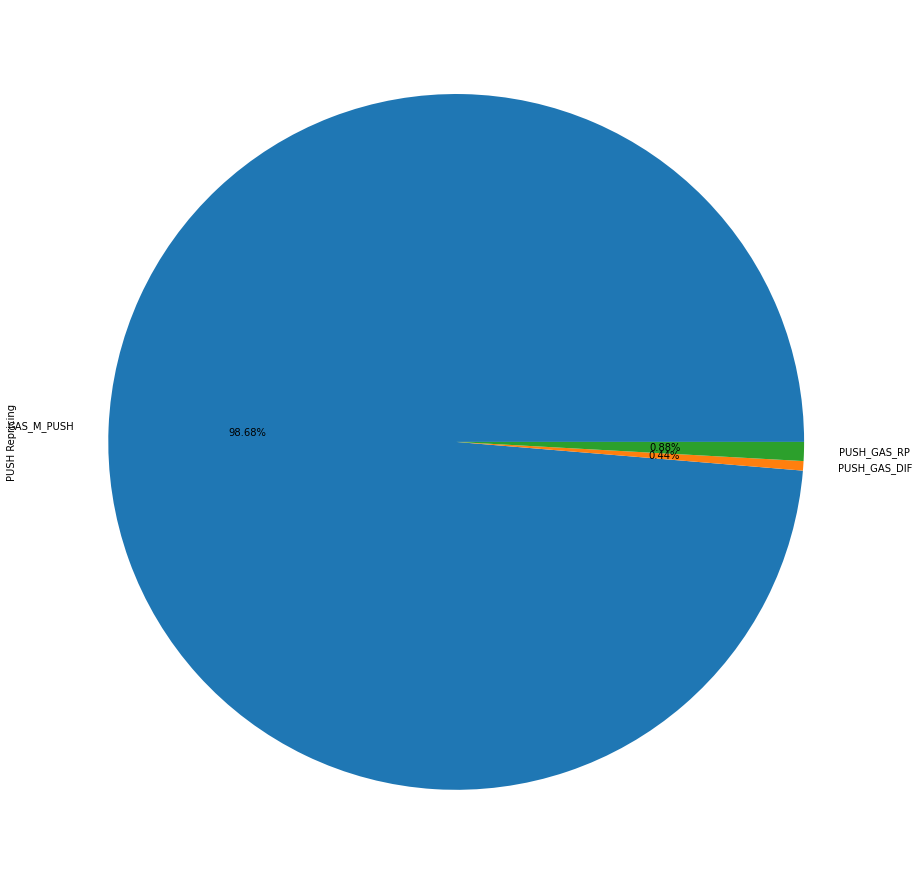

In [6]:
# Calculate gas cost not correspondng to PUSH opcodes
df['GAS_M_PUSH'] = df['Gas used'] - df['PUSH_GAS']
df[['GAS_M_PUSH', 'PUSH_GAS_DIF', 'PUSH_GAS_RP']].sum().plot(kind='pie', label='PUSH Repricing', figsize=(16,16), autopct=autopct)

The `0.44%` gas reduction represents `~50,000` gas per block:

In [7]:
df['Gas used'].mean()

11347353.829947148

In [8]:
df['PUSH_GAS_DIF'].mean()

49751.54633125129

### DUPx

In [9]:
gas_cost = 3
new_gas_cost = 2

dup_opcodes = ['DUP' + str(i) for i in range(1, 17)]
df['DUP_TOTAL'] = df[dup_opcodes].sum(axis=1)
df['DUP_GAS'] = df['DUP_TOTAL'] * gas_cost
df['DUP_GAS_RP'] = df['DUP_TOTAL'] * new_gas_cost
df['DUP_GAS_DIF'] = df['DUP_GAS'] - df['DUP_GAS_RP']
df['GAS_M_DUP'] = df['Gas used'] - df['DUP_GAS_DIF'] - df['DUP_GAS_RP']

df[['Block#', 'DUP_TOTAL', 'DUP_GAS', 'DUP_GAS_RP', 'DUP_GAS_DIF']]

,Block#,DUP_TOTAL,DUP_GAS,DUP_GAS_RP,DUP_GAS_DIF
0,8567259,13344,40032,26688,13344
1,8567261,24199,72597,48398,24199
2,8567262,25809,77427,51618,25809
3,8567263,26953,80859,53906,26953
4,8567265,20772,62316,41544,20772
...,...,...,...,...,...
29133,12817394,47447,142341,94894,47447
29134,12817398,49341,148023,98682,49341
29135,12817402,49824,149472,99648,49824
29136,12817403,42743,128229,85486,42743


After repricing DUPx costs from `3` to `2` we get an average reduction of `0.33%`:

In [10]:
def autopct(pct): # only show the label when it's > 10%
    return ('%.2f' % pct) + "%" if pct > 0 else ''

<AxesSubplot:ylabel='DUP Repricing'>

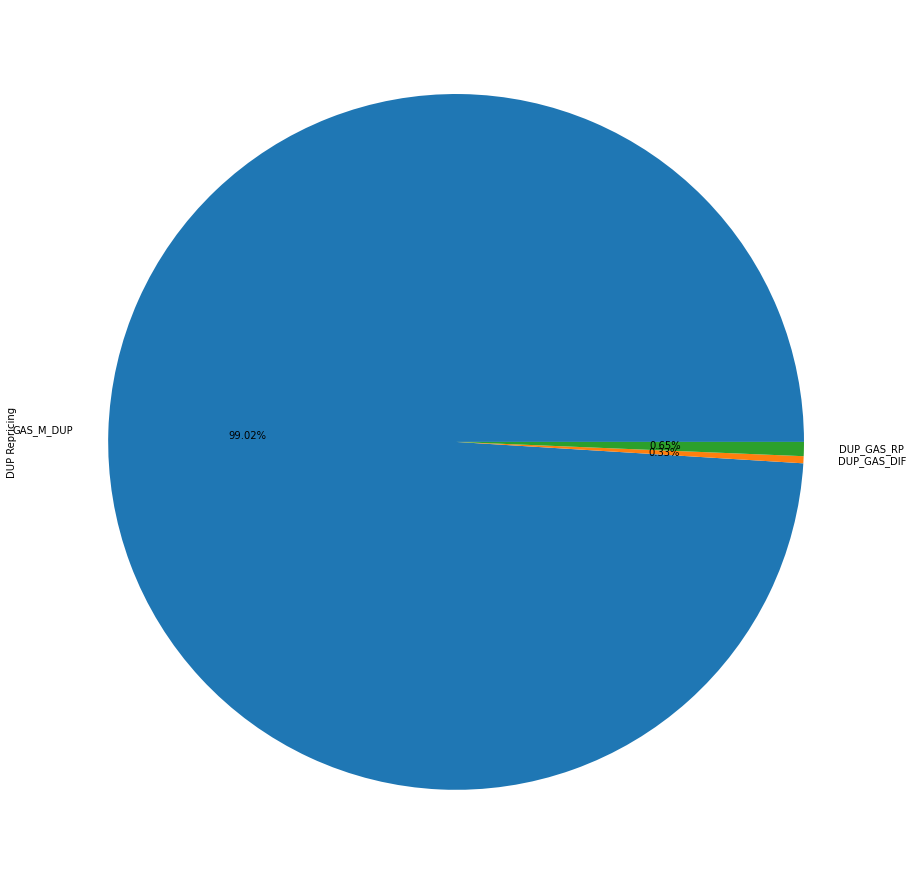

In [11]:
df[['GAS_M_DUP', 'DUP_GAS_DIF', 'DUP_GAS_RP']].sum().plot(kind='pie', label='DUP Repricing', figsize=(16,16), autopct=autopct)

Such `0.33%` gas reduction represents `~37,000` gas per block:

In [12]:
df['Gas used'].mean()

11347353.829947148

In [13]:
df['DUP_GAS_DIF'].mean()

37072.75379229872

### SWAPx

In [14]:
gas_cost = 3
new_gas_cost = 2

swap_opcodes = ['SWAP' + str(i) for i in range(1, 17)]
df['SWAP_TOTAL'] = df[swap_opcodes].sum(axis=1)
df['SWAP_GAS'] = df['SWAP_TOTAL'] * gas_cost
df['SWAP_GAS_RP'] = df['SWAP_TOTAL'] * new_gas_cost
df['SWAP_GAS_DIF'] = df['SWAP_GAS'] - df['SWAP_GAS_RP']
df['GAS_M_SWAP'] = df['Gas used'] - df['SWAP_GAS_DIF'] - df['SWAP_GAS_RP']

df[['Block#', 'SWAP_TOTAL', 'SWAP_GAS', 'SWAP_GAS_RP', 'SWAP_GAS_DIF']]

,Block#,SWAP_TOTAL,SWAP_GAS,SWAP_GAS_RP,SWAP_GAS_DIF
0,8567259,8773,26319,17546,8773
1,8567261,17420,52260,34840,17420
2,8567262,15465,46395,30930,15465
3,8567263,17315,51945,34630,17315
4,8567265,10527,31581,21054,10527
...,...,...,...,...,...
29133,12817394,28553,85659,57106,28553
29134,12817398,29237,87711,58474,29237
29135,12817402,28876,86628,57752,28876
29136,12817403,24335,73005,48670,24335


After repricing SWAPx costs from `3` to `2` we get an average reduction of `0.19%`:

In [15]:
def autopct(pct):
    return ('%.2f' % pct) + "%" if pct > 0 else ''

<AxesSubplot:ylabel='SWAP Repricing'>

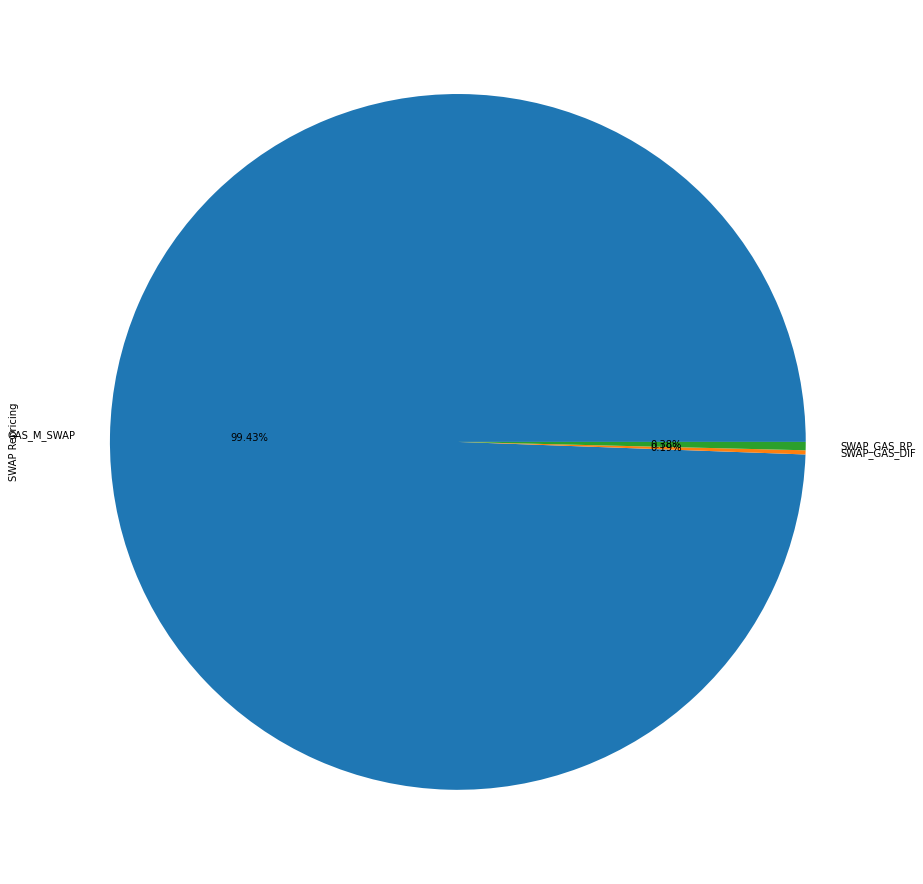

In [16]:
df[['GAS_M_SWAP', 'SWAP_GAS_DIF', 'SWAP_GAS_RP']].sum().plot(kind='pie', label='SWAP Repricing', figsize=(16,16), autopct=autopct)

`0.19%` represents `~21,000` gas.

In [17]:
df['Gas used'].mean()

11347353.829947148

In [18]:
df['SWAP_GAS_DIF'].mean()

21730.42401674789

### Arithmetic opcodes (ADD, SUB, LT, GT, ISZERO, SHL, SHR)

In [19]:
gas_cost = 3
new_gas_cost = 2

arith_opcodes = ['ADD', 'SUB', 'LT', 'GT', 'ISZERO', 'SHL', 'SHR']
df['ARITH_TOTAL'] = df[arith_opcodes].sum(axis=1)
df['ARITH_GAS'] = df['ARITH_TOTAL'] * gas_cost
df['ARITH_GAS_RP'] = df['ARITH_TOTAL'] * new_gas_cost
df['ARITH_GAS_DIF'] = df['ARITH_GAS'] - df['ARITH_GAS_RP']
df['GAS_M_ARITH'] = df['Gas used'] - df['ARITH_GAS_DIF'] - df['ARITH_GAS_RP']

df[['Block#', 'ARITH_TOTAL', 'ARITH_GAS', 'ARITH_GAS_RP', 'ARITH_GAS_DIF']]

,Block#,ARITH_TOTAL,ARITH_GAS,ARITH_GAS_RP,ARITH_GAS_DIF
0,8567259,7977,23931,15954,7977
1,8567261,17000,51000,34000,17000
2,8567262,19048,57144,38096,19048
3,8567263,19473,58419,38946,19473
4,8567265,17018,51054,34036,17018
...,...,...,...,...,...
29133,12817394,31071,93213,62142,31071
29134,12817398,33203,99609,66406,33203
29135,12817402,35398,106194,70796,35398
29136,12817403,27054,81162,54108,27054


After repricing arithmetic opcodes from `3` to `2` we get an average reduction of `0.21%`, which represents `~23,800`:

In [20]:
def autopct(pct):
    return ('%.2f' % pct) + "%"

<AxesSubplot:ylabel='ARITH Repricing'>

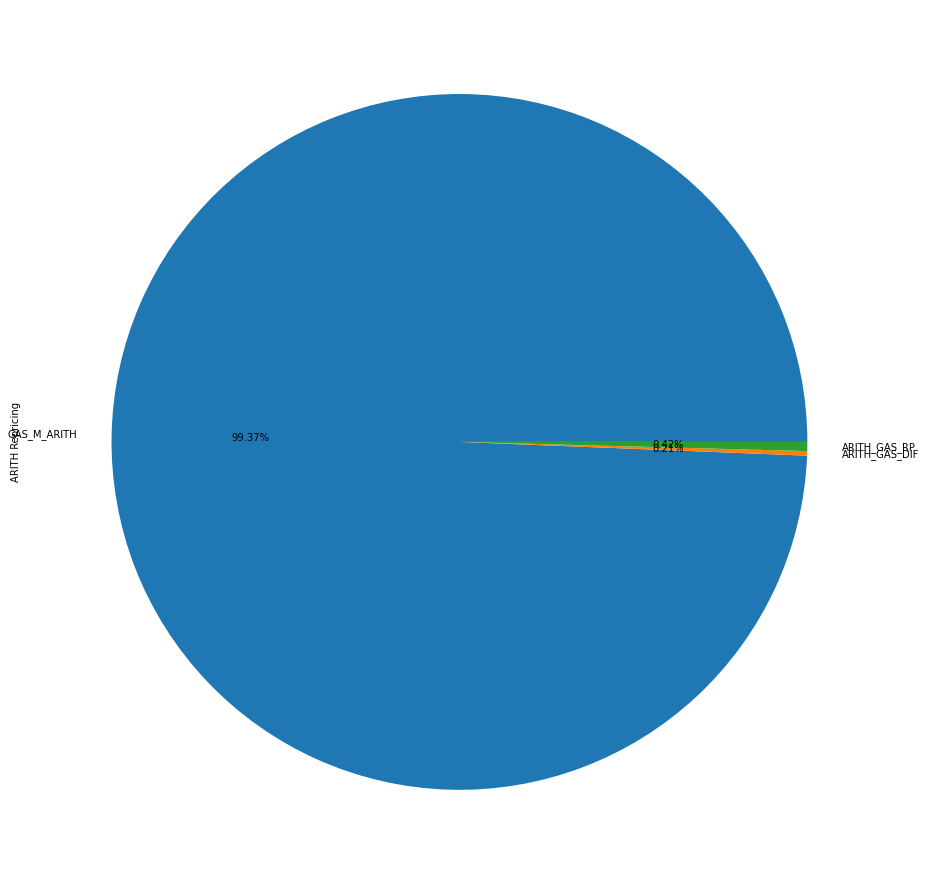

In [21]:
df[['GAS_M_ARITH', 'ARITH_GAS_DIF', 'ARITH_GAS_RP']].sum().plot(kind='pie', label='ARITH Repricing', figsize=(16, 16), autopct=autopct)

In [22]:
df['Gas used'].mean()

11347353.829947148

In [23]:
df['ARITH_GAS_DIF'].mean()

23824.74027043723

### Combined Gas Reduction

If we consider the previously mentioned opcodes we get a total gas reduction of `1.17%` which corresponds to `~132,000` gas.

|Opcodes  |Gas Reduction|
|---------|-------------|
|PUSHx    | 0.44%       |
|DUPx     | 0.33%       |
|SWAPx    | 0.19%       |
|ARITH    | 0.21%       |
|         |             |
|**Total**| 1.17%       |


<AxesSubplot:ylabel='Repricing'>

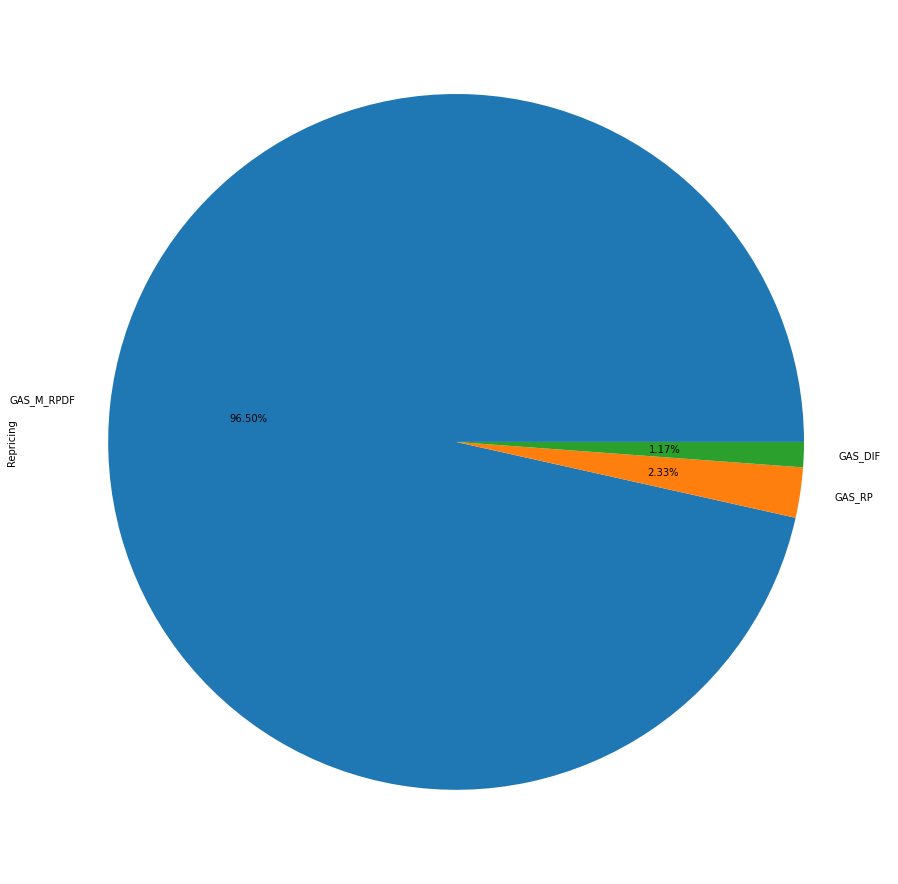

In [24]:
df['GAS_RP'] = df['PUSH_GAS_RP'] + df['SWAP_GAS_RP'] + df['DUP_GAS_RP'] + df['ARITH_GAS_RP']
df['GAS_DIF'] = df['PUSH_GAS_DIF'] + df['SWAP_GAS_DIF'] + df['DUP_GAS_DIF'] + df['ARITH_GAS_DIF']
df['GAS_M_RPDF'] = df['Gas used'] - df['GAS_DIF'] - df['GAS_RP']
df[['GAS_M_RPDF', 'GAS_RP', 'GAS_DIF']].sum().plot(kind='pie', label='Repricing', figsize=(16, 16), autopct=autopct)

In [25]:
df['GAS_DIF'].mean()

132379.46441073512

## Fractional gas

In [26]:
def calculate_percentage(a, b):
    return df[a].sum() / df[b].sum() * 100

def print_field_stats(field):
    perc = calculate_percentage(field, 'Gas used')
    gr = "Gas reduction: %2.4f" % perc
    gs = "%.4f" % df[field].mean()
    print(gr + ' %', '(' + gs + ')')
    
def print_reduction_table(fields):
    fields_dif = [ f + '_GAS_DIF' for f in fields]
    percs = [ calculate_percentage(f, 'Gas used') for f in fields_dif]
    gas = [ df[f].mean() for f in fields_dif]
    
    data = { 'Opcodes': fields,
            'Block Gas reduction': gas, 
            'Gas reduction (%)': percs }
    
    rd_df = pd.DataFrame(data)
    
    print(rd_df.to_markdown())

In [27]:
# Define fractional opcodes
fracc_opcodes = { 'JUMPDEST': { 'current_cost': 1, 'proposed_cost': 0.4},
                 'NOT': {'current_cost': 3, 'proposed_cost': 0.5},
                 'MUL': {'current_cost': 3, 'proposed_cost': 1.6}, 
                'PUSH': {'current_cost': 3, 'proposed_cost': 0.7},
                'DUP': {'current_cost': 3, 'proposed_cost': 0.6}}

In [28]:
df['PUSH_TOTAL'] = df[push_opcodes].sum(axis=1)
df['DUP_TOTAL'] = df[dup_opcodes].sum(axis=1)

df['PUSH_GAS'] = df['PUSH_TOTAL'] * fracc_opcodes['PUSH']['current_cost']
df['PUSH_GAS_RP'] = df['PUSH_TOTAL'] * fracc_opcodes['PUSH']['proposed_cost']
df['PUSH_GAS_DIF'] = df['PUSH_GAS'] - df['PUSH_GAS_RP']
df['GAS_M_PUSH'] = df['Gas used'] - df['PUSH_GAS_DIF'] - df['PUSH_GAS_RP']

df['DUP_GAS'] = df['DUP_TOTAL'] * fracc_opcodes['DUP']['current_cost']
df['DUP_GAS_RP'] = df['DUP_TOTAL'] * fracc_opcodes['DUP']['proposed_cost']
df['DUP_GAS_DIF'] = df['DUP_GAS'] - df['DUP_GAS_RP']
df['GAS_M_DUP'] = df['Gas used'] - df['DUP_GAS_DIF'] - df['DUP_GAS_RP']

for fo in fracc_opcodes:
    if fo != 'PUSH' and fo != 'DUP':
        df[fo + '_GAS'] = df[fo] * fracc_opcodes[fo]['current_cost']
        df[fo + '_GAS_RP'] = df[fo] * fracc_opcodes[fo]['proposed_cost']
        df[fo + '_GAS_DIF'] = df[fo + '_GAS'] - df[fo + '_GAS_RP']
        df['GAS_M_' + fo] = df['Gas used'] - df[fo + '_GAS_DIF'] - df[fo + '_GAS_RP']

        
df['GAS_RP'] = df['PUSH_GAS_RP'] + df['DUP_GAS_RP'] + df['JUMPDEST_GAS_RP'] + df['NOT_GAS_RP'] + df['MUL_GAS_RP']
df['GAS_DIF'] = df['PUSH_GAS_DIF'] + df['DUP_GAS_DIF'] + df['JUMPDEST_GAS_DIF'] + df['NOT_GAS_DIF'] + df['MUL_GAS_DIF']
df['GAS_M_RPDF'] = df['Gas used'] - df['GAS_DIF'] + df['GAS_RP']

In [29]:
print_reduction_table(['JUMPDEST', 'NOT', 'MUL', 'PUSH', 'DUP'])

|    | Opcodes   |   Block Gas reduction |   Gas reduction (%) |
|---:|:----------|----------------------:|--------------------:|
|  0 | JUMPDEST  |               7444.88 |          0.065609   |
|  1 | NOT       |               1078.46 |          0.00950407 |
|  2 | MUL       |               1849.16 |          0.0162959  |
|  3 | PUSH      |             114429    |          1.00842    |
|  4 | DUP       |              88974.6  |          0.7841     |


Based on [this](https://docs.google.com/spreadsheets/d/1OyvFQZON3AfwGLPgHutOEi03DSBI6rR5h8QS1YNqEpQ/edit#gid=0) analysis. Repricing the following opcodes considering a fractional gas cost:

|name     |Current Gas Cost|Proposed Gas cost|
|:--------|----------------|-----------------|
| JUMPDEST|       1        |  0.4            |
| NOT     |       3        |  0.5            |
| MUL     |       3        |  1.6            |
| PUSH*   |       3        |  0.7            | 
| DUP*    |       3        |  0.6            |

We get the following gas reductions per block:

| Opcodes   |   Block Gas reduction |   Gas reduction (%) |
|:----------|----------------------:|--------------------:|
| JUMPDEST  |              7444.88  |          0.065609   |
| NOT       |               862.768 |          0.00760325 |
| MUL       |              2641.65  |          0.0232799  |
| PUSH      |             99503.1   |          0.876884   |
| DUP       |             74145.5   |          0.653417   |

### Combined 

Considering Fractional Gas Repricing for PUSHx, DUPx, JUMPDEST, NOT, and MUL, we get a gas reduction of `1.86%`. Which corresponds to `~213,775.66` gas per block.

<AxesSubplot:ylabel='Fraccional Gas Repricing'>

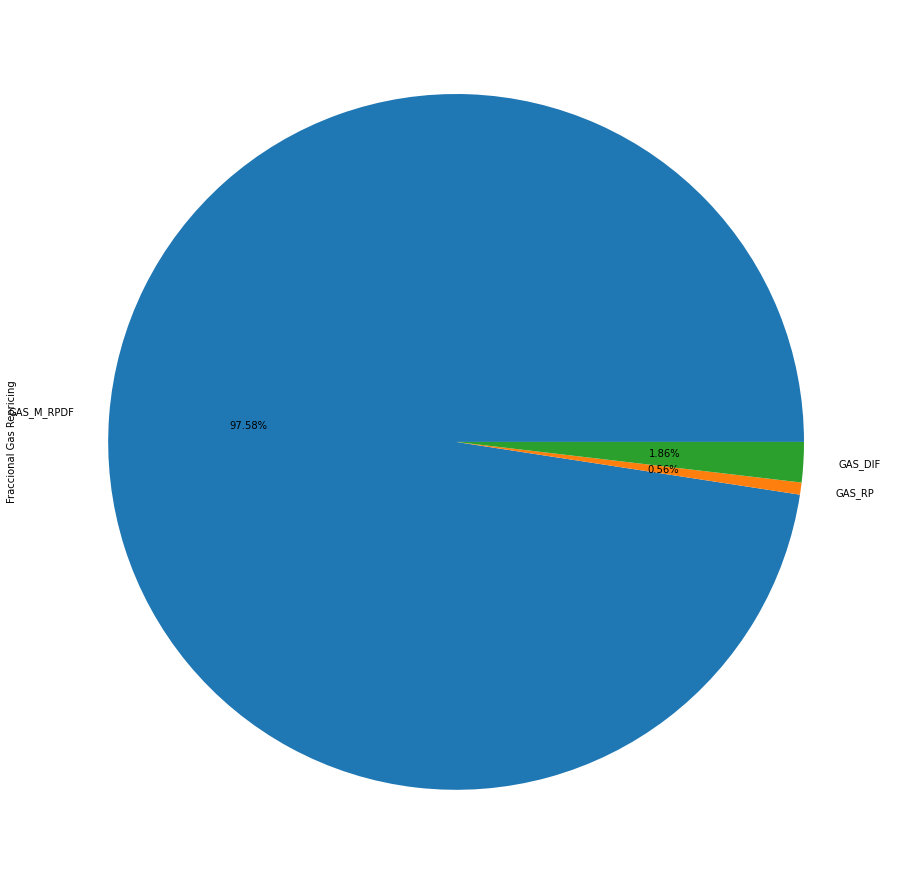

In [30]:
df[['GAS_M_RPDF', 'GAS_RP', 'GAS_DIF']].sum().plot(kind='pie', label='Fraccional Gas Repricing', figsize=(16, 16), autopct=autopct)

In [31]:
df['GAS_DIF'].mean()

213775.6657457616

## Fractional/Rounded Gas Repricing

Reference: <https://notes.ethereum.org/wt5uVsd4SRGATo5-ekIMfw>

|Opcode  | Gas Cost | Proposed Gas Cost |
|--------|----------|-------------------|
|PUSH*   | 3        | 1                 |
|DUP*    | 3        | 1                 |
|SWAP*   | 3        | 1                 |
|ADD     | 3        | 1                 |
|MUL     | 5        | 2                 |
|SUB     | 3        | 1                 |
|LT      | 3        | 1                 |
|GT      | 3        | 1                 |
|SLT     | 3        | 1                 |
|SGT     | 3        | 1                 |
|EQ      | 3        | 1                 |
|ISZERO  | 3        | 1                 |
|AND     | 3        | 1                 |
|OR      | 3        | 1                 |
|XOR     | 3        | 1                 |
|NOT     | 3        | 1                 |
|POP     | 2        | 1                 |
|PC      | 2        | 1                 |

After applying the new gas cost we get the following reduction in gas usage:

| Opcodes   |   Block Gas reduction |   Gas reduction (%) |
|:----------|----------------------:|--------------------:|
| PUSH      |           99503.1     |         0.876884    |
| DUP       |           74145.5     |         0.653417    |
| SWAP      |           21730.4     |         0.191502    |
| ADD       |           19144.4     |         0.168713    |
| MUL       |            2641.65    |         0.0232799   |
| SUB       |            5711.26    |         0.0503312   |
| LT        |            4463.32    |         0.0393336   |
| GT        |            2665.27    |         0.0234881   |
| SLT       |             179.283   |         0.00157995  |
| SGT       |              43.4516  |         0.000382923 |
| EQ        |            6875.49    |         0.0605911   |
| ISZERO    |           12956       |         0.114176    |
| AND       |           11485.9     |         0.101221    |
| OR        |             639.824   |         0.00563853  |
| XOR       |              10.5886  |         9.33132e-05 |
| NOT       |             862.768   |         0.00760325  |
| POP       |           27867.7     |         0.245588    |
| PC        |               7.31313 |         6.44479e-05 |



In [32]:
# Define fractional opcodes
fracc_opcodes = { 'ADD': {'current_cost': 3, 'proposed_cost': 1},
                 'MUL': {'current_cost': 3, 'proposed_cost': 1},
                 'SUB': {'current_cost': 3, 'proposed_cost': 1},
                 'LT': {'current_cost': 3, 'proposed_cost': 1},
                 'GT': {'current_cost': 3, 'proposed_cost': 1},
                 'SLT': {'current_cost': 3, 'proposed_cost': 1},
                 'SGT': {'current_cost': 3, 'proposed_cost': 1},
                 'EQ': {'current_cost': 3, 'proposed_cost': 1},
                 'ISZERO': {'current_cost': 3, 'proposed_cost': 1},
                 'AND': {'current_cost': 3, 'proposed_cost': 1},
                 'OR': {'current_cost': 3, 'proposed_cost': 1},
                 'XOR': {'current_cost': 3, 'proposed_cost': 1},
                 'NOT': {'current_cost': 3, 'proposed_cost': 1},
                 'POP': {'current_cost': 3, 'proposed_cost': 1},
                 'PC': {'current_cost': 3, 'proposed_cost': 1},
                'PUSH': {'current_cost': 3, 'proposed_cost': 1},
                'DUP': {'current_cost': 3, 'proposed_cost': 1}}

In [33]:
df['PUSH_TOTAL'] = df[push_opcodes].sum(axis=1)
df['DUP_TOTAL'] = df[dup_opcodes].sum(axis=1)

df['PUSH_GAS'] = df['PUSH_TOTAL'] * fracc_opcodes['PUSH']['current_cost']
df['PUSH_GAS_RP'] = df['PUSH_TOTAL'] * fracc_opcodes['PUSH']['proposed_cost']
df['PUSH_GAS_DIF'] = df['PUSH_GAS'] - df['PUSH_GAS_RP']
df['GAS_M_PUSH'] = df['Gas used'] - df['PUSH_GAS_DIF'] - df['PUSH_GAS_RP']

df['DUP_GAS'] = df['DUP_TOTAL'] * fracc_opcodes['DUP']['current_cost']
df['DUP_GAS_RP'] = df['DUP_TOTAL'] * fracc_opcodes['DUP']['proposed_cost']
df['DUP_GAS_DIF'] = df['DUP_GAS'] - df['DUP_GAS_RP']
df['GAS_M_DUP'] = df['Gas used'] - df['DUP_GAS_DIF'] - df['DUP_GAS_RP']

for fo in fracc_opcodes:
    if fo != 'PUSH' and fo != 'DUP':
        df[fo + '_GAS'] = df[fo] * fracc_opcodes[fo]['current_cost']
        df[fo + '_GAS_RP'] = df[fo] * fracc_opcodes[fo]['proposed_cost']
        df[fo + '_GAS_DIF'] = df[fo + '_GAS'] - df[fo + '_GAS_RP']
        df['GAS_M_' + fo] = df['Gas used'] - df[fo + '_GAS_DIF'] - df[fo + '_GAS_RP']
        
df['GAS_RP'] = df['PUSH_GAS_RP'] + df['DUP_GAS_RP'] + df['SWAP_GAS_RP'] + df['ADD_GAS_RP'] + df['MUL_GAS_RP'] + df['SUB_GAS_RP'] + df['LT_GAS_RP'] + df['GT_GAS_RP'] + df['SLT_GAS_RP'] + df['SGT_GAS_RP'] + df['EQ_GAS_RP'] + df['ISZERO_GAS_RP'] + df['AND_GAS_RP'] + df['OR_GAS_RP'] + df['XOR_GAS_RP'] + df['NOT_GAS_RP'] + df['POP_GAS_RP'] + df['PC_GAS_RP']
df['GAS_DIF'] = df['PUSH_GAS_DIF'] + df['DUP_GAS_DIF'] + df['SWAP_GAS_DIF'] + df['ADD_GAS_DIF'] + df['MUL_GAS_DIF'] + df['SUB_GAS_DIF'] + df['LT_GAS_DIF'] + df['GT_GAS_DIF'] + df['SLT_GAS_DIF'] + df['SGT_GAS_DIF'] + df['EQ_GAS_DIF'] + df['ISZERO_GAS_DIF'] + df['AND_GAS_DIF'] + df['OR_GAS_DIF'] + df['XOR_GAS_DIF'] + df['NOT_GAS_DIF'] + df['POP_GAS_DIF'] + df['PC_GAS_DIF']
df['GAS_M_RPDF'] = df['Gas used'] - df['GAS_DIF'] + df['GAS_RP']

In [34]:
print_reduction_table(['PUSH', 'DUP', 'SWAP', 'ADD', 'MUL', 'SUB', 'LT', 'GT', 'SLT', 'SGT', 'EQ', 'ISZERO', 'AND', 'OR', 'XOR', 'NOT', 'POP', 'PC'])

|    | Opcodes   |   Block Gas reduction |   Gas reduction (%) |
|---:|:----------|----------------------:|--------------------:|
|  0 | PUSH      |           99503.1     |         0.876884    |
|  1 | DUP       |           74145.5     |         0.653417    |
|  2 | SWAP      |           21730.4     |         0.191502    |
|  3 | ADD       |           19144.4     |         0.168713    |
|  4 | MUL       |            2641.65    |         0.0232799   |
|  5 | SUB       |            5711.26    |         0.0503312   |
|  6 | LT        |            4463.32    |         0.0393336   |
|  7 | GT        |            2665.27    |         0.0234881   |
|  8 | SLT       |             179.283   |         0.00157995  |
|  9 | SGT       |              43.4516  |         0.000382923 |
| 10 | EQ        |            6875.49    |         0.0605911   |
| 11 | ISZERO    |           12956       |         0.114176    |
| 12 | AND       |           11485.9     |         0.101221    |
| 13 | OR        |       

### Combined

Considering the combined reduction of previous opcodes, we get a total reduction of `~2.49%` which corresponds to a saving of `290,933` gas per block.

<AxesSubplot:ylabel='Fraccional Gas Repricing'>

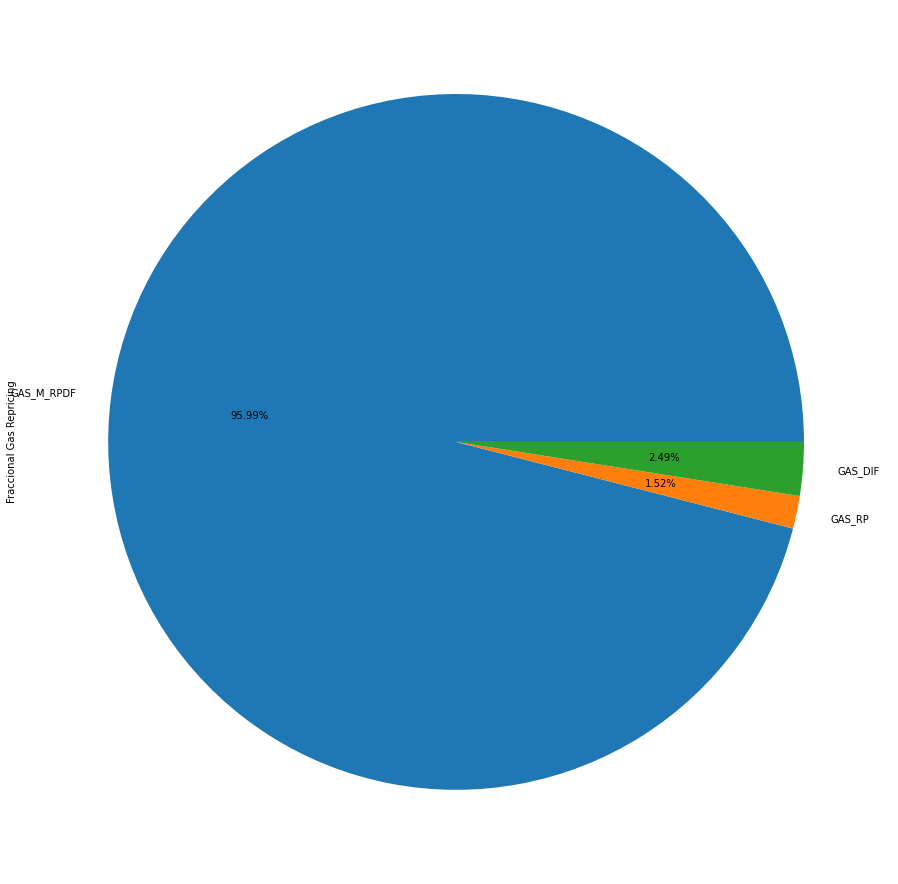

In [35]:
df[['GAS_M_RPDF', 'GAS_RP', 'GAS_DIF']].sum().plot(kind='pie', label='Fraccional Gas Repricing', figsize=(16, 16), autopct=autopct)

In [36]:
df['GAS_DIF'].mean()

290933.34460155125